#### Import required libraries

In [14]:
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt

#### Load Data

In [15]:
df = pd.read_csv(r'age_gender.csv')
df.head()

,age,ethnicity,gender,img_name,pixels
0,1,2,0,20161219203650636.jpg.chip.jpg,129 128 128 126 127 130 133 135 139 142 145 14...
1,1,2,0,20161219222752047.jpg.chip.jpg,164 74 111 168 169 171 175 182 184 188 193 199...
2,1,2,0,20161219222832191.jpg.chip.jpg,67 70 71 70 69 67 70 79 90 103 116 132 145 155...
3,1,2,0,20161220144911423.jpg.chip.jpg,193 197 198 200 199 200 202 203 204 205 208 21...
4,1,2,0,20161220144914327.jpg.chip.jpg,202 205 209 210 209 209 210 211 212 214 218 21...


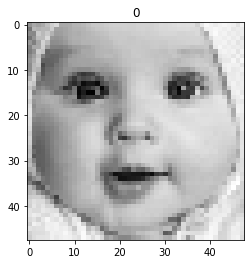

In [17]:
# Show image of index:1001
index = 1001
image = np.fromstring(df['pixels'][index], sep = ' ', dtype = np.uint8).reshape((48,48))
plt.title(df['ethnicity'][index])
plt.imshow(image, cmap ="gray")
plt.show()

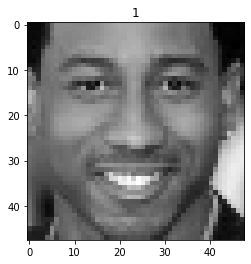

In [18]:
# Show image of index:5005
index = 5005
image = np.fromstring(df['pixels'][index], sep = ' ', dtype = np.uint8).reshape((48,48))
plt.title(df['ethnicity'][index])
plt.imshow(image, cmap ="gray")
plt.show()

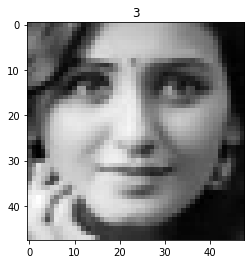

In [19]:
# Show image of index:7001
index = 7001
image = np.fromstring(df['pixels'][index], sep = ' ', dtype = np.uint8).reshape((48,48))
plt.title(df['ethnicity'][index])
plt.imshow(image, cmap ="gray")
plt.show()

In [20]:
data = df.drop("img_name", axis=1)
columns = ["age","gender","ethnicity"]
y = data.drop("pixels", axis = 1)
x = data.drop(columns, axis = 1)

In [27]:
x.head(5)

,pixels
0,129 128 128 126 127 130 133 135 139 142 145 14...
1,164 74 111 168 169 171 175 182 184 188 193 199...
2,67 70 71 70 69 67 70 79 90 103 116 132 145 155...
3,193 197 198 200 199 200 202 203 204 205 208 21...
4,202 205 209 210 209 209 210 211 212 214 218 21...


In [28]:
y.head()

,age,ethnicity,gender
0,1,2,0
1,1,2,0
2,1,2,0
3,1,2,0
4,1,2,0


In [29]:
y.nunique()

age          104
ethnicity      5
gender         2
dtype: int64

#### Data Distribution

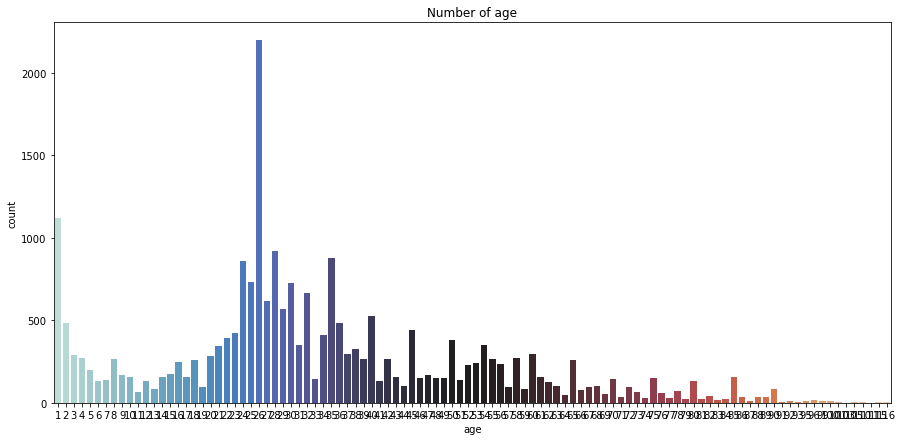

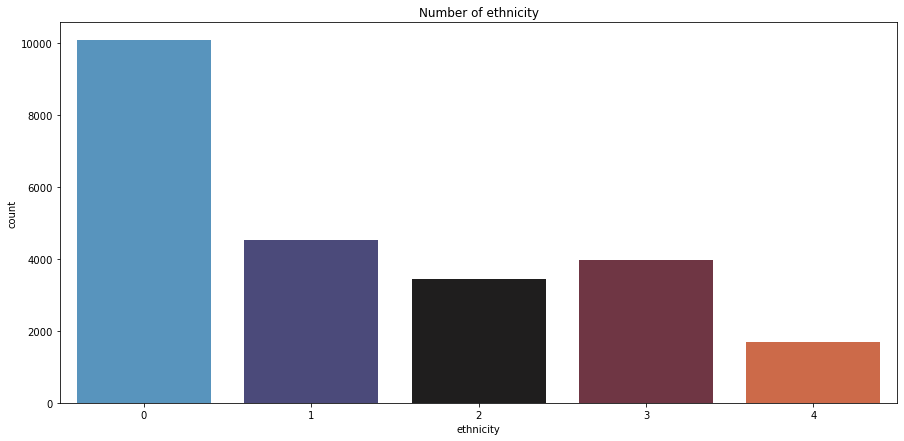

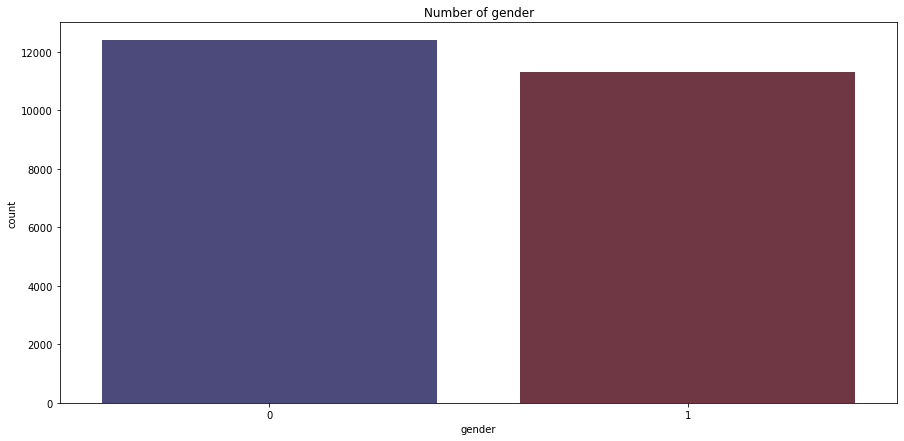

In [32]:
import seaborn as sns
# import warnings
import warnings
# filter warnings
warnings.filterwarnings('ignore')

for i in y.columns :
    plt.figure(figsize=(15,7))
    g = sns.countplot(y[i], palette="icefire")
    plt.title("Number of {}".format(i))

#### Prepare data for training 

In [4]:
ethnicity_mapping = {0:"White", 1:"Black", 2:"Asian", 3:"Indian", 4:"Hispanic"}
gender_mapping = {0:"Male", 1:"Female"}

In [5]:
def get_image(row):
    '''
    functions takes a series and returns the image and it's labels
    '''
    age = row['age']
    ethnicity = row['ethnicity']
    gender = row['gender']
    image = np.array(row['pixels'].split(), 'float64')
    image = image.reshape(48, 48) / 255.0

    return image, age, ethnicity, gender

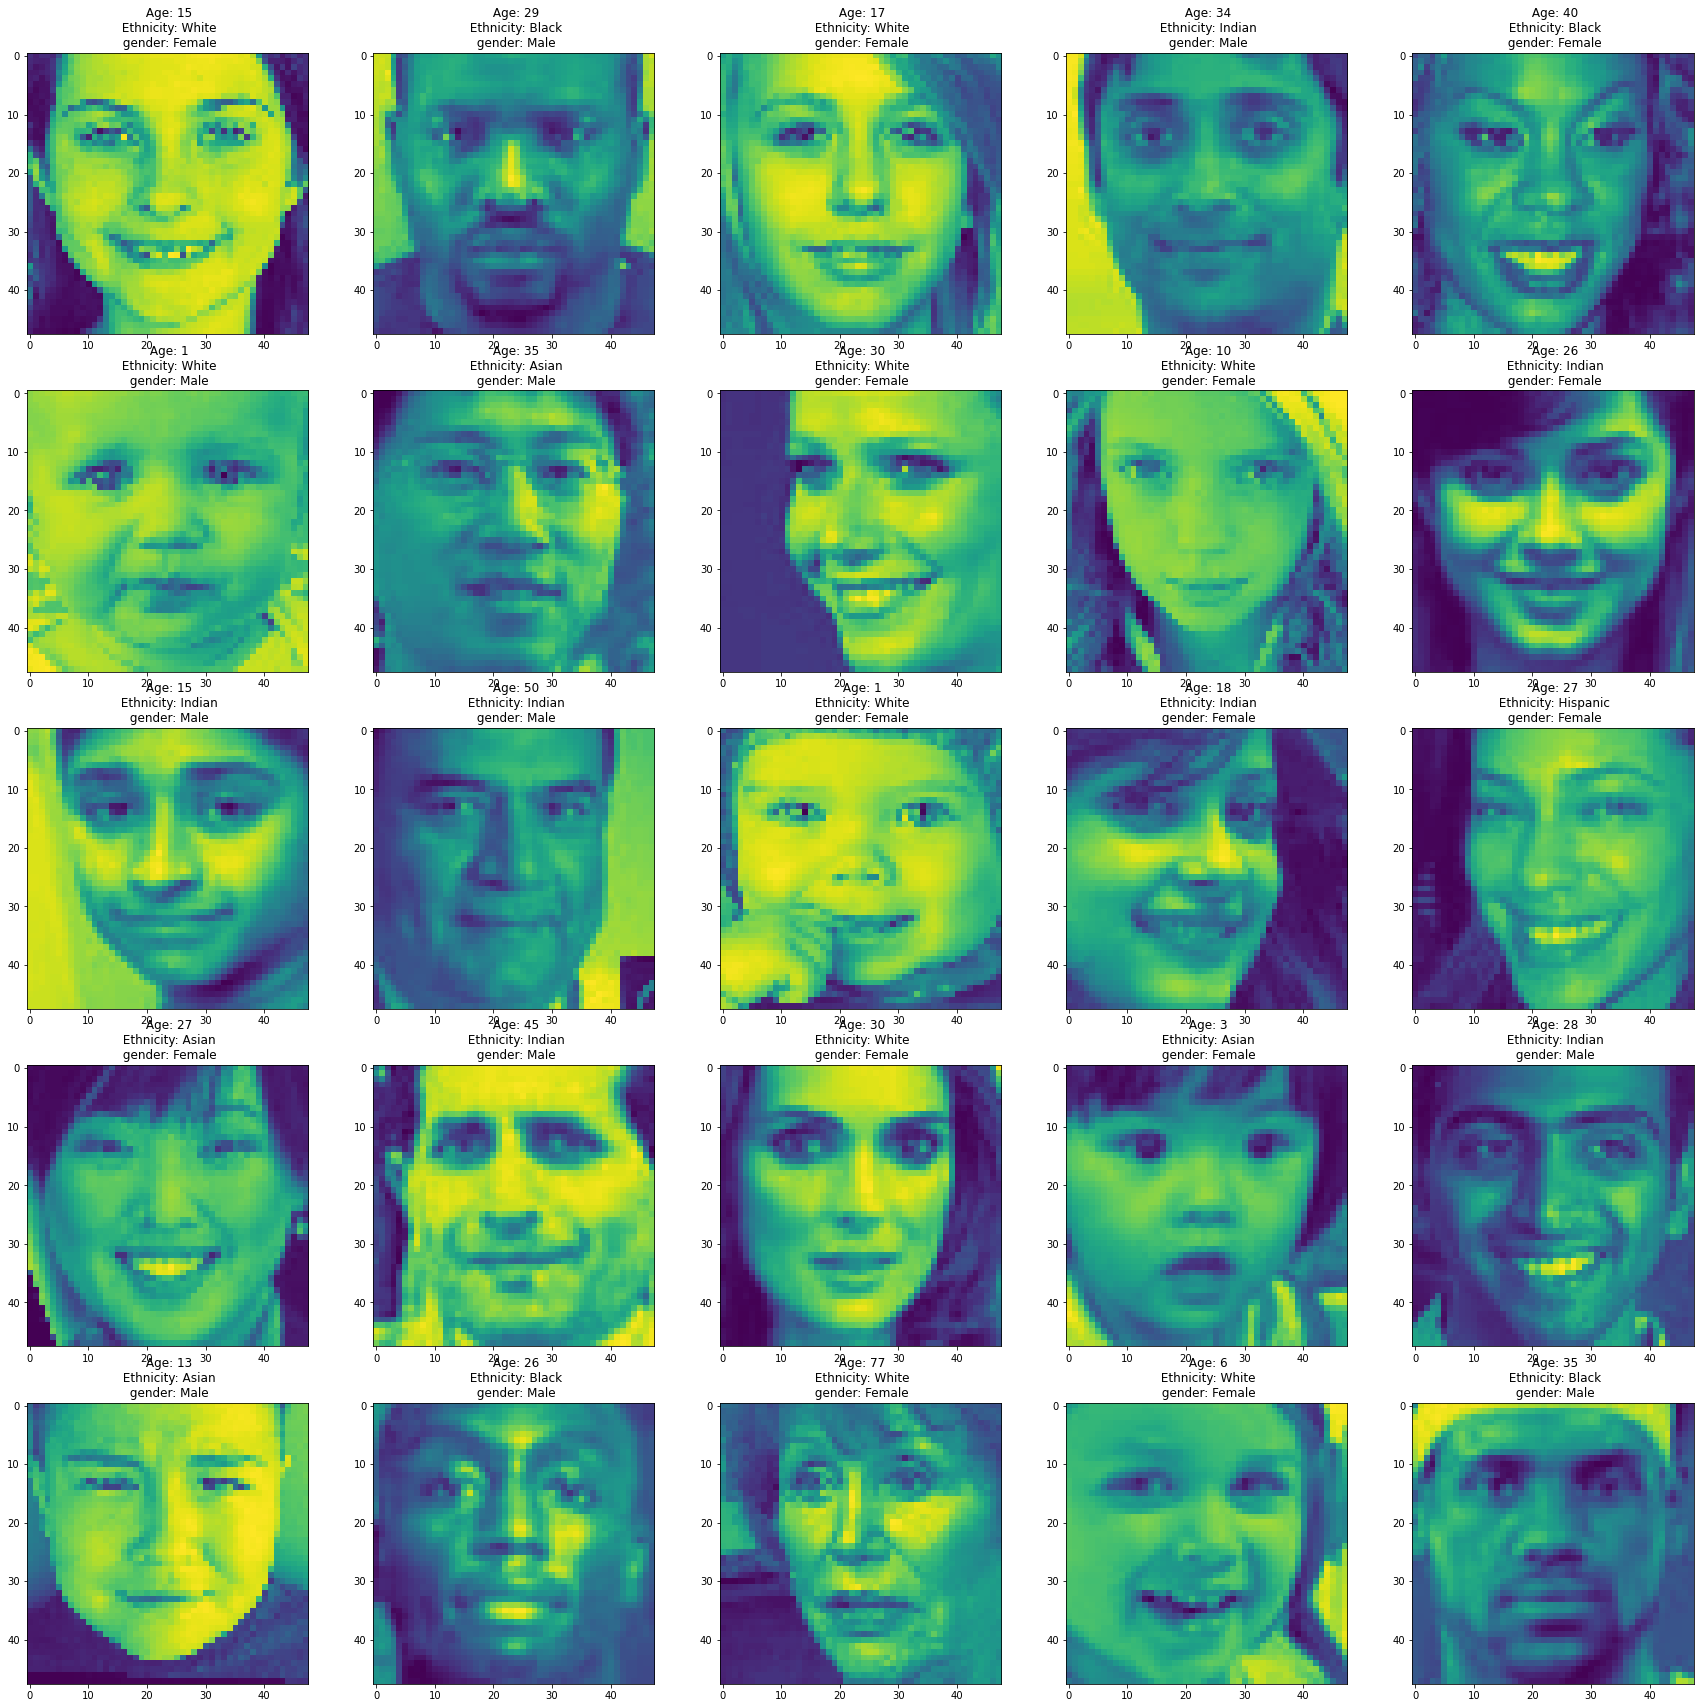

In [6]:
#Show Images
def show_images():
  plt.figure(figsize=(30, 30))

  for i in range(25):
    #select random image
    index = np.random.randint(0, len(df))
    image, age, ethnicity, gender = get_image(df.iloc[index])

    plt.subplot(5, 5, i+1)
    plt.imshow(image)
    plt.title(' Age: {}\n Ethnicity: {}\n gender: {}'.format(age, ethnicity_mapping[ethnicity], gender_mapping[gender]))
    # plt.axes('off')

  plt.show()

show_images()

In [7]:
'''
Defining data generator
'''
from tensorflow.keras.utils import Sequence
class DataGenerator(Sequence):
    'Generates data for Keras'
    def __init__(self, name, images, age, ethnicity, gender, batch_size=32, shuffle=True):
        
        
        'Initialization'
        self.name = name
        self.batch_size = batch_size
        self.images = images
        self.age = age
        self.ethnicity = ethnicity
        self.gender = gender
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        #print('returning length')
        #print(int(np.floor(len(self.sentences) / self.batch_size)))
        return int(np.floor(len(self.age) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        #print(index)
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        images = [self.images[k] for k in indexes]
        age = [self.age[k] for k in indexes]
        ethnicity = [self.ethnicity[k] for k in indexes]
        gender = [self.gender[k] for k in indexes]
        
        images = np.array(images)
        age = np.array(age)
        ethnicity = np.array(ethnicity)
        gender = np.array(gender)
        
        X = images
        y = [age, ethnicity, gender]
        
        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.age))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)


    def add_data(self, images, age, ethnicity, gender):
        self.images=np.append(self.images, images, axis=0)
        self.age=np.append(self.age, age, axis=0)
        self.ethnicity=np.append(self.ethnicity, ethnicity, axis=0)
        self.gender=np.append(self.gender, gender, axis=0)
        self.on_epoch_end()

In [8]:
'''
function to make generators
'''
def generate_images(df, generator_name, batch_size=32):
    
    total_images = len(df)
    num_batches = total_images // batch_size
    batch_count = 0
    while batch_count < num_batches:
        x_batch = np.zeros((batch_size, 48, 48, 1))
        age_batch = np.zeros((batch_size,))
        ethnicity_batch = np.zeros((batch_size,))
        gender_batch = np.zeros((batch_size,))

        for i in range(batch_size):
            index = np.random.randint(0, total_images)
            image, age, ethnicity, gender = get_image(df.iloc[index])
            image = image.reshape(48, 48, 1)

            x_batch[i] = image / 255.0
            age_batch[i] = age
            ethnicity_batch[i] = ethnicity
            gender_batch[i] = gender
            
        if batch_count == 0:
            generator = DataGenerator(generator_name, x_batch, age_batch, ethnicity_batch, gender_batch)
        else:
            generator.add_data(x_batch, age_batch, ethnicity_batch, gender_batch)
            
        batch_count += 1

    return generator

In [9]:
# Create train and validation data generators

df_val = df.sample(1000)
df_train = df.sample(len(df) - 1000)

train_gen = generate_images(df_train, generator_name='training_generator')
validation_gen = generate_images(df_val, generator_name='validation_generator')

#### Define Model

In [10]:
from tensorflow.keras.layers import Convolution2D, MaxPool2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout, Activation, Input
from tensorflow.keras.models import Model
import tensorflow as tf

Here I am using multilabel classification model to predict Age, Gender and Ethnicity of person

In [11]:
input = Input(shape=(48, 48, 1), name='input')

conv_1 = Convolution2D(32, 3, activation='relu')(input)
conv_2 = Convolution2D(32, 3, activation='relu')(conv_1)
pool_1 = MaxPooling2D(pool_size=(2, 2))(conv_2)

flat_1 = Flatten(name='flat_1')(pool_1)
gender = Dense(1, activation='sigmoid', name='gender')(flat_1)

drop_1 = Dropout(0.2)(pool_1)

conv_3 = Convolution2D(64, 3, activation='relu')(drop_1)
conv_4 = Convolution2D(128, 3, activation='relu')(conv_3)
pool_2 = MaxPooling2D(pool_size=(2, 2))(conv_4)

flat_2 = Flatten(name='flat_2')(pool_2)
age = Dense(1, name='age')(flat_2)

drop_2 = Dropout(0.2)(pool_2)

conv_5 = Convolution2D(64, 3, activation='relu')(drop_2)
conv_6 = Convolution2D(128, 3, activation='relu')(conv_5)

flat_3 = Flatten(name='flat_3')(conv_6)
ethnicity = Dense(5, activation='softmax', name='ethnicity')(flat_3)

model = Model(inputs=input, outputs=[age, ethnicity, gender])
model.compile(
    loss={
        'age': 'mean_squared_error',
        'ethnicity': 'sparse_categorical_crossentropy',
        'gender': 'binary_crossentropy'
    },
    metrics={
        'age':'mean_squared_error',
        'ethnicity': 'sparse_categorical_accuracy',
        'gender': 'accuracy'
    }, 
    optimizer='adam'
)

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 48, 48, 1)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 46, 46, 32)   320         ['input[0][0]']                  
                                                                                                  
 conv2d_1 (Conv2D)              (None, 44, 44, 32)   9248        ['conv2d[0][0]']                 
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 22, 22, 32)   0           ['conv2d_1[0][0]']               
                                                                                              

#### Training 

In [12]:
class Logger(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        print() #just for spacing between two epochs stats

In [13]:
model.fit(train_gen, 
              validation_data=validation_gen, 
              epochs=100,
              callbacks=[Logger(), tf.keras.callbacks.TensorBoard(log_dir='./logs')],
              verbose=1)

Epoch 1/100
709/709 [==============================] - 96s 133ms/step - loss: 429.3034 - age_loss: 427.1478 - ethnicity_loss: 1.4594 - gender_loss: 0.6959 - age_mean_squared_error: 427.1478 - ethnicity_sparse_categorical_accuracy: 0.4249 - gender_accuracy: 0.5041 - val_loss: 430.5197 - val_age_loss: 428.3801 - val_ethnicity_loss: 1.4486 - val_gender_loss: 0.6909 - val_age_mean_squared_error: 428.3801 - val_ethnicity_sparse_categorical_accuracy: 0.4284 - val_gender_accuracy: 0.5333
Epoch 2/100
709/709 [==============================] - 92s 130ms/step - loss: 407.6591 - age_loss: 405.5187 - ethnicity_loss: 1.4499 - gender_loss: 0.6906 - age_mean_squared_error: 405.5187 - ethnicity_sparse_categorical_accuracy: 0.4255 - gender_accuracy: 0.5255 - val_loss: 430.6585 - val_age_loss: 428.5235 - val_ethnicity_loss: 1.4506 - val_gender_loss: 0.6845 - val_age_mean_squared_error: 428.5235 - val_ethnicity_sparse_categorical_accuracy: 0.4284 - val_gender_accuracy: 0.6099
Epoch 3/100
709/709 [=======

Accuracy on validation data

Age (mse): 59.0 %

Ethnicity (accuracy): 71.26 %

Gender (accuracy): 86.4 % 